In [1]:
import cv2
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pprint import pprint
from glob import glob
# 프로그램이 의도한 상황으로 돌아가고 있는 중인지 상태 확인 모듈
from tqdm import tqdm 

In [2]:
!pip install tqdm

You should consider upgrading via the 'c:\users\it강남-e강의장(강사용)\appdata\local\programs\python\python38\python.exe -m pip install --upgrade pip' command.


In [2]:
LABEL_INT_DICT = np.unique(pd.read_csv('ucf11_train_vid.csv')['label'])
LABEL_STR_DICT = {k:v for v, k in enumerate(LABEL_INT_DICT)}
pprint(LABEL_INT_DICT)
pprint(LABEL_STR_DICT)

array(['biking', 'diving', 'golf', 'juggle', 'jumping', 'riding',
       'shooting', 'spiking', 'swing', 'tennis', 'walk'], dtype=object)
{'biking': 0,
 'diving': 1,
 'golf': 2,
 'juggle': 3,
 'jumping': 4,
 'riding': 5,
 'shooting': 6,
 'spiking': 7,
 'swing': 8,
 'tennis': 9,
 'walk': 10}


In [3]:
import albumentations as A
import cv2
import math
import tensorflow as tf
from tensorflow import keras

class DataGenerator(keras.utils.Sequence):
    def __init__(self, batch_size, image_size,
                 mode='train', shuffle=True):
        assert mode in ['train', 'valid']
        self.mode = mode
        self.shuffle = shuffle
        self.batch_size = batch_size
        self.image_size = image_size
        
        if self.mode == 'train':
            self.transform = A.Compose([
                A.HorizontalFlip(p=0.5),
                A.ShiftScaleRotate(
                    p=0.5,
                    shift_limit=0.05,
                    scale_limit=0.05,
                    rotate_limit=15,
                ),
            ])
        
        self.img_paths = glob(
            f'UCF11_updated_png/{mode}/*.png'
        )

    def __len__(self):
        return math.ceil(len(self.img_paths) / self.batch_size)
    
    def __getitem__(self, idx):
        strt = idx * self.batch_size
        fin = (idx + 1) * self.batch_size
        data = self.img_paths[strt:fin]
    
        batch_x, batch_y = self.get_data(data)

        return np.array(batch_x), np.array(batch_y)
        
    def get_data(self, data):
        batch_x = []
        batch_y = []
    
        for img_path in data:
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, (self.image_size, self.image_size))

            if self.mode == 'train':
                augmented = self.transform(image=img)
                img = augmented['image']
            
            img = img.astype('float32')
            img = img / 255.
            
            label = img_path.split('\\')[-1]. \
                 split('_')[0]
            label = LABEL_STR_DICT[label]
                 
            batch_x.append(img)
            batch_y.append(label)
        
        return batch_x, batch_y
                     
    def on_epoch_end(self):
        if self.shuffle:
            random.shuffle(self.img_paths)
            
train_generator = DataGenerator(
    mode='train',
    batch_size=128,
    image_size=256,
    shuffle=True)

valid_generator = DataGenerator(
    mode='valid',
    batch_size=128,
    image_size=256,
    shuffle=True)

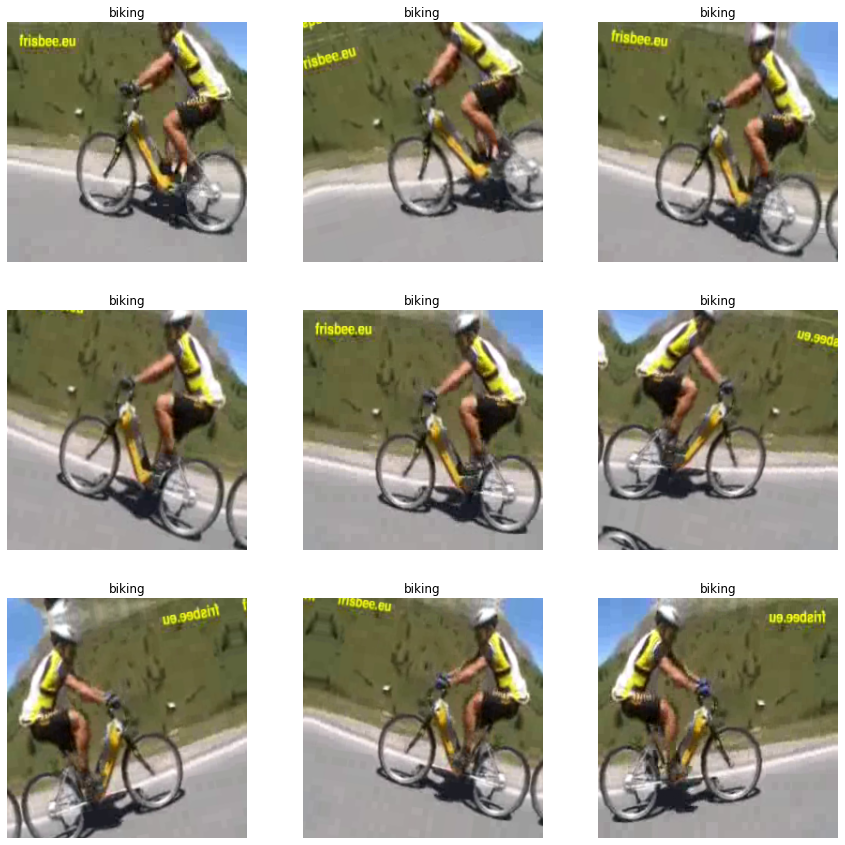

In [4]:
for batch in train_generator:
    X, y = batch
    plt.figure(figsize=(15, 15))
    
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(X[i])
        plt.title(LABEL_INT_DICT[y[i]])
        plt.axis('off')
    
    break

In [7]:
import os
import tensorflow_hub as hub

os.environ['CUDA_VISIBLE_DEVICES'] = '1'
model = tf.keras.Sequential([
    hub.KerasLayer("https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b0/feature_vector/2",
                   trainable=True),  # Can be True, see below.
    tf.keras.layers.Dense(len(LABEL_INT_DICT), activation='softmax')
])
model.build([None, 256, 256, 3])  # Batch input shape.

adam = keras.optimizers.Adam(lr=0.0001)
model.compile(
    optimizer=adam,
    loss='sparse_categorical_crossentropy',
    metrics='accuracy'
)

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_1 (KerasLayer)  (None, 1280)              5919312   
                                                                 
 dense_1 (Dense)             (None, 11)                14091     
                                                                 
Total params: 5,933,403
Trainable params: 5,872,795
Non-trainable params: 60,608
_________________________________________________________________


In [8]:
os.mkdir('ucf11_weights')

In [9]:
filepath = 'ucf11_weights/{epoch:02d}-{val_accuracy:.2f}.hdf5'
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath, monitor = 'val_loss', verbose=1, save_best_only=True,
    save_weights_only=False, mode='min'
)

history = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=10,
    verbose=1,
    callbacks=[
        model_checkpoint
    ],
)

Epoch 1/10
18/18 [==============================] - ETA: 0s - loss: 2.4703 - accuracy: 0.0791 
Epoch 00001: val_loss improved from inf to 2.31554, saving model to ucf11_weights\01-0.18.hdf5
18/18 [==============================] - 404s 21s/step - loss: 2.4703 - accuracy: 0.0791 - val_loss: 2.3155 - val_accuracy: 0.1836
Epoch 2/10
18/18 [==============================] - ETA: 0s - loss: 2.1295 - accuracy: 0.3541 
Epoch 00002: val_loss improved from 2.31554 to 1.94452, saving model to ucf11_weights\02-0.61.hdf5
18/18 [==============================] - 375s 21s/step - loss: 2.1295 - accuracy: 0.3541 - val_loss: 1.9445 - val_accuracy: 0.6091
Epoch 3/10
18/18 [==============================] - ETA: 0s - loss: 1.6424 - accuracy: 0.7314 
Epoch 00003: val_loss improved from 1.94452 to 1.40213, saving model to ucf11_weights\03-0.84.hdf5
18/18 [==============================] - 372s 21s/step - loss: 1.6424 - accuracy: 0.7314 - val_loss: 1.4021 - val_accuracy: 0.8382
Epoch 4/10
18/18 [===========

In [1]:
import matplotlib.pyplot as plt
history = history.history

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(history['loss'], label='train')
plt.plot(history['val_loss'], label='val')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title("Loss")

plt.subplot(1, 2, 2)
plt.plot(history['accuracy'], label='train')
plt.plot(history['val_accuracy'], label='val')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title("Accuracy")
plt.show()

NameError: name 'history' is not defined

In [11]:
csv_path = 'ucf11_valid_vid.csv'
valid_df = pd.read_csv(csv_path)

correct = 0
for i, elem in tqdm(valid_df.iterrows(), total=len(valid_df)):
    cap = cv2.VideoCapture(
        elem['file_path']
    )
    
    preds = []
    while True:
        ret, frame = cap.read()
        
        if not ret:
            break
            
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frame = cv2.resize(frame, (256, 256))
        frame = frame.astype('float32')
        frame /= 255.
        
        pred = model.predict(frame[np.newaxis, ...])
        preds.append(pred)
    
    preds = np.array(preds).mean(axis=0)
    label = LABEL_INT_DICT[np.argmax(preds)]
    
    if label == elem['label']:
        correct += 1
    
    cap.release()


print('Accuracy : ', correct / len(valid_df))

100%|██████████████████████████████████████████████████████████████████████████████████| 55/55 [08:07<00:00,  8.86s/it]

Accuracy :  0.9818181818181818
